In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
# =======================================================================================
# PERFORMANCE PREPROCESSING INCLUDING - MAKING DATA FOR Y-TRAIN/Y-TEST, BEST MESHES, THICKNESS TRENDS
# =======================================================================================


####################################################################################################################
####################################################----INPUTS----###################################################
#####################################################################################################################

datasets = ['DATASET_24']
test_indices_no = 50
# main path
main_path = os.path.join(os.getcwd(),'DATASETS',datasets[0],'surr_results')
# Create a results folder in the main directory if it doesn't exist
os.makedirs(main_path, exist_ok=True)

# parent path
parent_path = os.path.abspath(os.path.join(os.getcwd(),'..'))     # parent directory
parent_path = os.path.join(parent_path,'DATASETS/') 

# DEFINE DATASET PATH
dataset_file_path = os.path.join(parent_path,datasets[0],'00_geometry_generation/dataset')

# chosen combination method for seismic load
xy_combining_method = 'max'



In [3]:
# Colours

# Define custom color
colour_dark_blue = (11/255, 58/255, 64/255)  # Normalize RGB values to range [0, 1]
colour_teal = (15/255, 117/255, 118/255)  # Normalize RGB values to range [0, 1]
colour_maroon = (170/255, 80/255, 38/255)  # Normalize RGB values to range [0, 1]
colour_gold = (190/255, 181/255, 111/255)  # Normalize RGB values to range [0, 1]
colour_orange= (241/255, 118/255, 34/255)  # Normalize RGB values to range [0, 1]

colour_list = [colour_teal, colour_orange, colour_maroon]

In [4]:
# Load the train labels
train_labels_path = os.path.join(main_path, f"train_labels_{xy_combining_method}.txt")
train_labels_dict_path = os.path.join(main_path, f"train_labels_dict_{xy_combining_method}.json")

if os.path.exists(train_labels_dict_path):
    train_labels_np = np.loadtxt(os.path.join(main_path, f"train_labels_{xy_combining_method}.txt"), delimiter=',')
    BOOLEAN_generate_train_labels =  False

    pa_dict_sorted = {}
    pa_dict_sorted = {}
    with open(train_labels_dict_path, 'r') as file:
        pa_dict_sorted= json.load(file)

else:
    BOOLEAN_generate_train_labels = True

print(f"Generate training labels?: {BOOLEAN_generate_train_labels}")

Generate training labels?: False


In [5]:
# CONVERTING THE HEIGHT AND PERFORMANCE DATA INTO DICTIONARIES

'''
this part of code is copied from s9_performance_evaluation_filtering_crease_height_comparison.py. but the parent_path is different as this is a parent directory
'''


#####################################################################################################################
####################################################----DEFINITIONS----###############################################
#####################################################################################################################


def make_mesh_dict_from_files(path, type_of_data):
    '''
    DESCRIPTION: makes a dictionary of meshes from json files of meshes
    INPUT: folder path, 
          type of data is 'pa' for performance evaluation and 'gg' for geometry generation
    OUTPUT: the dictionary of meshes with performance analysis
    '''
    # get filenames from parent_path folder
    files = os.listdir(path)

    if type_of_data == 'pa':
        length = -10

        # make into mesh
        mesh_data = {}
        mesh_data['x']={}
        mesh_data['y']={}

        for file_name in files:
            x_y = file_name[-6]
            # if file_name[-6] == 'x':
            mesh_name = file_name[:length]
            mesh_data[x_y][mesh_name]={}
            filepath_mesh = os.path.join(path,file_name)

            with open(filepath_mesh, 'r') as file:
                mesh_data[x_y][mesh_name] = json.load(file)


        return mesh_data


    elif type_of_data == 'gg':
        length = -8
        
        # make into mesh
        mesh_data = {}
        for file_name in files:
            mesh_name = file_name[:length]
            mesh_data[mesh_name]={}
            filepath_mesh = os.path.join(path,file_name)

            with open(filepath_mesh, 'r') as file:
                mesh_data[mesh_name] = json.load(file)
        return mesh_data


def extract_keys_from_nested_dict(pa_dict, pa_keys, type_of_data):
    '''
    DESCRIPTION: Extract out the necessary performance criteria keys (Stability, Strength, Stiffness)
    INPUT: pa_dict is the performance analysis dictionary created from the definition make_mesh_dict_from_files()
    '''
    # Extract out the necessary performance criteria keys (Stability, Strength, Stiffness)
    pa_dict_sss = {mesh: {key: pa_dict[mesh][key] for key in pa_keys} for mesh in pa_dict}
    

    # Check whether there is failure in Stability or Strength (Stiffness check is already done)
    if type_of_data == 'failure':  
        for mesh in pa_dict_sss:
            if pa_dict_sss[mesh]['Buckling_Load_Factor'] > 1 : 
                pa_dict_sss[mesh]['Buckling_Load_Factor_Failure'] = 'False'
            else:
                pa_dict_sss[mesh]['Buckling_Load_Factor_Failure'] = 'True'

            if pa_dict_sss[mesh]['Utilization'] < 1 : 
                pa_dict_sss[mesh]['Utilization_Failure'] = 'False'
            else:
                pa_dict_sss[mesh]['Utilization_Failure'] = 'True'
    
    return pa_dict_sss

#####################################################################################################################
####################################################----SOLVER----###############################################
#####################################################################################################################


if BOOLEAN_generate_train_labels == True:

    parent_path_dict= {}
    parent_path_dict['pa']={}
    parent_path_dict['gg']={}
    for i, val in enumerate(datasets):
        parent_path_dict['pa'][val]= os.path.join(parent_path,val,'01_performance_evaluation/dataset_separate/' )
        parent_path_dict['gg'][val]= os.path.join(parent_path,val,'00_geometry_generation/dataset_separate/dataset_separate_height_thickness/' )
        

    # keys for SSS and failure
    keys_sss_failure  = ['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios']
    # keys for SSS
    keys_sss  = ['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios']
    # key for height
    key_height = ['Height_of_vault/m'] 
    


    ################## json to dictionary + extracting only SSS keys

    # Performance evaluation dictionary
    pa_dict = {}
    pa_dict['with_failure'] = {}
    pa_dict['without_failure'] = {}
    for dataset, path in parent_path_dict['pa'].items():
        mesh_dict = make_mesh_dict_from_files(path, 'pa')
        # pa_dict['with_failure'] = extract_keys_from_nested_dict(mesh_dict, keys_sss_failure, 'no_failure')
        # pa_dict['without_failure'] = extract_keys_from_nested_dict(mesh_dict, keys_sss, 'no_failure')

    # height dictionary
    gg_height_dict = {}
    for dataset, path in parent_path_dict['gg'].items():
        gg_height_dict= make_mesh_dict_from_files(path, 'gg')
        gg_height_dict= extract_keys_from_nested_dict(gg_height_dict, key_height, 'gg')


In [33]:
# CONVERTING THE HEIGHT, MASS INTO A DICTIONARY, SORT, AND SAVE
 

import pickle

parent_path_dict= {}
parent_path_dict['gg']={}
for i, val in enumerate(datasets):
    parent_path_dict['gg'][val]= os.path.join(parent_path,val,'00_geometry_generation/dataset_separate/dataset_separate_height_thickness/' )


# key for mass
key_mass = ["Mass/kg"]
key_height = ['Height_of_vault/m']
# mass dictionary
gg_mass_dict = {}
for dataset, path in parent_path_dict['gg'].items():
    gg_mass_dict= make_mesh_dict_from_files(path, 'gg')
    gg_mass_dict= extract_keys_from_nested_dict(gg_mass_dict, key_mass, 'gg')
    gg_height_dict= make_mesh_dict_from_files(path, 'gg')
    gg_height_dict= extract_keys_from_nested_dict(gg_height_dict, key_height, 'gg')



# REORDERING THE DICTIONARY SO MESHES ARE IN ORDER

# Convert nested dictionary to DataFrame
df_mass = pd.DataFrame.from_dict(gg_mass_dict)
df_height = pd.DataFrame.from_dict(gg_height_dict)



# Sort column names in ascending order considering numerical part
sorted_columns_mass= sorted(df_mass.columns, key=lambda x: int(x.split('mesh_')[-1]))
sorted_columns_height = sorted(df_height.columns, key=lambda x: int(x.split('mesh_')[-1]))

# # Reorder DataFrame columns
df_mass = df_mass[sorted_columns_mass]
df_height = df_height[sorted_columns_height]


gg_mass_dict = df_mass.to_dict('list')
gg_height_dict = df_height.to_dict('list')

gg_dict = {}
gg_dict['mass']= gg_mass_dict
gg_dict['height']= gg_height_dict

with open(os.path.join(dataset_file_path,'gg_dict.pkl'), 'wb') as file:
    pickle.dump(gg_dict, file, protocol=pickle.HIGHEST_PROTOCOL)



In [6]:
# CALCULATING THE INTERSTOREY DRIFT RATIOS IF NEEEDED

if BOOLEAN_generate_train_labels == True:

    for x_y in mesh_dict.keys():
        for mesh in mesh_dict[x_y].keys():
            height = gg_height_dict[mesh]['Height_of_vault/m']
            displacement_list = [mesh_dict[x_y][mesh]['Max_Displacement/mm']]
            height_list = [3, 3+height]


            '''this part of code is from performance_evaluation_final_clean_wall_7.gh file'''

            # q is the behaviour factor (same as material)
            q =1.0
            # v is the reduction factor based on the importance class as importance class is II, v = 0.5
            v=0.5


            height_list = [val for i,val in enumerate(height_list) if i%2==1]

            # ds is the displacement factored by the behaviour factor q
            ds = [q*i/1000 for i in displacement_list]

            # dr is the interstorey drift
            dr = []
            d1 = 0
            for i, val in enumerate (ds):
                d2 = val
                dresultant = d2-d1
                dr.append(dresultant)
                d1=val



            drv = []
            failure = []
            counter = 0
            for i, val in enumerate(dr):
                drv.append(dr[i]*v/height_list[i])
                if dr[i]*v< 0.01*height_list[i]:
                    failure.append('False')
                else:
                    counter +=1
                    failure.append('True')
            #if counter > 0:
            #    print('NOTE: Interstorey drift is above acceptable standards')

            mesh_dict[x_y][mesh]['Interstorey_Drift_Ratios'] = [str(round(i,8))+'h' for i in drv]
            mesh_dict[x_y][mesh]['Interstorey_Drift_Ratios'] = mesh_dict[x_y][mesh]['Interstorey_Drift_Ratios'] [0]
            mesh_dict[x_y][mesh]['Interstorey_Drift_Failure'] = failure
            mesh_dict[x_y][mesh]['Interstorey_Drift_Failure'] = mesh_dict[x_y][mesh]['Interstorey_Drift_Failure'][0]

In [7]:
# COMBINING THE X-DIRECTION AND Y_DIRECTION SESMIC INTERNAL REACTIONS

if BOOLEAN_generate_train_labels == True:

    mesh_dict['combined'] = {}
    for x_y in mesh_dict.keys():
        for mesh in mesh_dict['y'].keys():
            mesh_dict['combined'][mesh] = {}
            for performance_key in mesh_dict['y'][mesh].keys():
                x_value = mesh_dict['x'][mesh][performance_key]
                y_value = mesh_dict['y'][mesh][performance_key]

                # if performance_key == 'Interstorey_Drift_Ratios':
                if xy_combining_method == 'srss':
                    if performance_key in ['Buckling_Load_Factor','Max_Shear_Stress/MPa', 'Max_Shear_Force/KN', 'Utilization', 'Max_Tensile_Stress/MPa' , 'Max_Bending_Stress/MPa', 'Avg_Displacement/mm', 'Max_Displacement/mm', 'Max_Principal_Stress/MPa', 'Avg_Shear_Force/KN', 'Avg_Bending_Moment/KNm',  'Max_Bending_Moment/KNm', 'Max_Compresive_Stress/MPa' ]: 
                        mesh_dict['combined'][mesh][performance_key]  = (x_value**2 + y_value**2)**(0.5)

                    if performance_key == 'Interstorey_Drift_Ratios':
                        mesh_dict['combined'][mesh][performance_key]  = (float(x_value[:-1])**2 + float(y_value[:-1])**2)**(0.5)


                elif xy_combining_method == 'max':
                    if performance_key in ['Max_Shear_Stress/MPa', 'Max_Shear_Force/KN', 'Utilization', 'Max_Tensile_Stress/MPa' , 'Max_Bending_Stress/MPa', 'Avg_Displacement/mm', 'Max_Displacement/mm', 'Max_Principal_Stress/MPa', 'Avg_Shear_Force/KN', 'Avg_Bending_Moment/KNm',  'Max_Bending_Moment/KNm', 'Max_Compresive_Stress/MPa' ]: 
                        mesh_dict['combined'][mesh][performance_key]  = max(x_value, y_value)
                    
                    if performance_key == 'Interstorey_Drift_Ratios':
                        x_value = float(x_value[:-1])
                        y_value = float(y_value[:-1])
                        mesh_dict['combined'][mesh][performance_key]  = max(x_value, y_value)

                    if performance_key == 'Buckling_Load_Factor': 
                        mesh_dict['combined'][mesh][performance_key]  = min(x_value, y_value)

In [8]:
# MAKE PERFORMANCE EVALUATION CSV
path_new = os.path.abspath(os.path.join(main_path,'..'))
pa_df_path = os.path.join(path_new,'pa_dataframe.csv')

if os.path.isfile(pa_df_path):
    print('The performance evaluation dataframe ALREADY EXISTS')
else:
    pa_df = pd.DataFrame(mesh_dict['combined'])
    pa_df.loc['Interstorey_Drift_Ratios'] =  pa_df.loc['Interstorey_Drift_Ratios'].apply(lambda x : str(x) +'h')
    print(pa_df.iloc[:,:2])
    print('Performance evaluation dataframe GENERATED')


# pa_df.to_csv(pa_df_path,index = True)

The performance evaluation dataframe ALREADY EXISTS


In [9]:
# TAKING OUT THE SSS AND REORDERING

if BOOLEAN_generate_train_labels == True:

    # Taking out the SSS
    pa_dict['without_failure'] = extract_keys_from_nested_dict(mesh_dict['combined'], keys_sss, 'no_failure')


    # REORDERING THE DICTIONARY SO MESHES ARE IN ORDER

    # Convert nested dictionary to DataFrame
    df_pa_dict_without_failure = pd.DataFrame.from_dict(pa_dict['without_failure'])

    # Sort column names in ascending order considering numerical part
    sorted_columns_pa_without_failure = sorted(df_pa_dict_without_failure.columns, key=lambda x: int(x.split('mesh_')[-1]))
    # Reorder DataFrame columns
    df_pa_dict_without_failure = df_pa_dict_without_failure[sorted_columns_pa_without_failure]
        
    pa_dict_sorted = {}
    pa_dict_sorted['without_failure'] = df_pa_dict_without_failure.to_dict('list')

In [10]:
# PERFORMANCE DATA - LABELS FOR Y_TRAIN AND Y_TEST

if BOOLEAN_generate_train_labels == True:

    train_labels_sss = []
    for mesh in pa_dict_sorted['without_failure']:
        train_labels_sss.append(list(pa_dict_sorted['without_failure'][mesh]))

    train_labels_np = np.array(train_labels_sss)
    train_labels_np = train_labels_np.astype('float32')

In [11]:
# FAILURE IN SSS

pa_dict_sorted['with_failure'] = {}
pa_dict_sorted['with_failure'] = copy.deepcopy(pa_dict_sorted['with_failure'])

list_sss = {}
list_sss['Buckling_Load_Factor'] = []
list_sss['Utilization'] = []
list_sss['Interstorey_Drift_Ratios'] = []

b_bool = False
u_bool = False
d_bool = False

sss_keys = ['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']


for mesh in pa_dict_sorted['without_failure'].keys():

    pa_dict_sorted['with_failure'][mesh] = {}
    
    buckling = pa_dict_sorted['without_failure'][mesh][0]
    util = pa_dict_sorted['without_failure'][mesh][1]
    drift = pa_dict_sorted['without_failure'][mesh][2]

    if buckling < 1:
        b_bool = True
    else:
        b_bool = False
    if util > 1:
        u_bool = True
    else:
        u_bool = False
    if drift > 0.010:
        d_bool = True
    else:
        d_bool = False

    pa_dict_sorted['with_failure'][mesh]['Buckling_Load_Factor'] = [buckling, b_bool]
    pa_dict_sorted['with_failure'][mesh]['Utilization'] = [util, u_bool] 
    pa_dict_sorted['with_failure'][mesh]['Interstorey_Drift_Ratios'] = [drift, d_bool]

    list_sss['Buckling_Load_Factor'].append(buckling)
    list_sss['Utilization'].append(util)
    list_sss['Interstorey_Drift_Ratios'].append(drift)


In [12]:
# SAVE THE TRAIN LABELS

if BOOLEAN_generate_train_labels == True:

    train_labels_path = os.path.join(main_path, f"train_labels_{xy_combining_method}.txt")
    np.savetxt(train_labels_path, train_labels_np, delimiter=",")

    # SAVE description file
    train_labels_dict_path = os.path.join(main_path, f"train_labels_dict_{xy_combining_method}.json")
    with open(train_labels_dict_path, 'w') as json_file:
        json.dump(pa_dict_sorted, json_file)

In [13]:
# MEAN AND STANDARD DEVIATION OF DATASET IN SSS 
# mean_dict. key is sss criterias and values are mean of whole dataset
# std_dict. key is sss criterias and values are standard deviation of whole dataset
# failure_dict. keys is sss criteria and values are failure values for each criteria

buckling_list = []
util_list =[]
drift_list = []

for mesh in pa_dict_sorted['without_failure'].keys():
    buckling_list.append(pa_dict_sorted['without_failure'][mesh][0])
    util_list.append(pa_dict_sorted['without_failure'][mesh][1])
    drift_list.append(pa_dict_sorted['without_failure'][mesh][2])

mean_dict = {}
mean_dict['Buckling_Load_Factor'] = np.mean(buckling_list)
mean_dict['Utilization'] = np.mean(util_list)
mean_dict['Interstorey_Drift_Ratios'] = np.mean(drift_list)

std_dict= {}
std_dict['Buckling_Load_Factor'] = np.std(buckling_list)
std_dict['Utilization'] = np.std(util_list)
std_dict['Interstorey_Drift_Ratios'] = np.std(drift_list)

failure_dict = {}
failure_dict['Buckling_Load_Factor'] = 1
failure_dict['Utilization'] = 1
failure_dict['Interstorey_Drift_Ratios'] = 0.01


In [14]:
# BEST MESHES IN EACH CRITERIA LIST

best_mesh_qty = 50

sorted_dict_sss ={}
best_sss_meshes = {}
sorted_dict_sss['Buckling_Load_Factor'] = dict(sorted(pa_dict_sorted['without_failure'].items(), key=lambda item: item[1][0], reverse=True))
sorted_dict_sss['Utilization'] = dict(sorted(pa_dict_sorted['without_failure'].items(), key=lambda item: item[1][1], reverse=False))
sorted_dict_sss['Interstorey_Drift_Ratios'] = dict(sorted(pa_dict_sorted['without_failure'].items(), key=lambda item: item[1][2], reverse=False))
best_sss_meshes['Buckling_Load_Factor'] =  list(sorted_dict_sss['Buckling_Load_Factor'] .keys())[:best_mesh_qty]  
best_sss_meshes['Utilization'] = list(sorted_dict_sss['Utilization'] .keys())[:best_mesh_qty]
best_sss_meshes['Interstorey_Drift_Ratios'] = list(sorted_dict_sss['Interstorey_Drift_Ratios'] .keys())[:best_mesh_qty]

print(pa_dict_sorted['with_failure'])
print(best_sss_meshes['Utilization'])




{'mesh_0': {'Buckling_Load_Factor': [15.695331, False], 'Utilization': [10.878619, True], 'Interstorey_Drift_Ratios': [0.0036012, False]}, 'mesh_1': {'Buckling_Load_Factor': [20.383875, False], 'Utilization': [12.469341, True], 'Interstorey_Drift_Ratios': [0.0033542, False]}, 'mesh_2': {'Buckling_Load_Factor': [2.467948, False], 'Utilization': [11.033591, True], 'Interstorey_Drift_Ratios': [0.00841904, False]}, 'mesh_3': {'Buckling_Load_Factor': [20.806535, False], 'Utilization': [5.907684, True], 'Interstorey_Drift_Ratios': [0.00197305, False]}, 'mesh_4': {'Buckling_Load_Factor': [17.458329, False], 'Utilization': [10.041392, True], 'Interstorey_Drift_Ratios': [0.00251683, False]}, 'mesh_5': {'Buckling_Load_Factor': [21.272856, False], 'Utilization': [9.830398, True], 'Interstorey_Drift_Ratios': [0.00287915, False]}, 'mesh_6': {'Buckling_Load_Factor': [4.791181, False], 'Utilization': [4.521911, True], 'Interstorey_Drift_Ratios': [0.00228037, False]}, 'mesh_7': {'Buckling_Load_Factor'

In [15]:
# BEST MESHES IN EACH CRITERIA DICTIONARY (best_sss_dict)

def extract_keys_from_dict(my_dict,list_keys):
    new_dict = {key: my_dict[key] for key in list_keys if key in my_dict}
    return new_dict

best_sss_dict = {}
best_sss_dict['Buckling_Load_Factor'] = extract_keys_from_dict(pa_dict_sorted['with_failure'], best_sss_meshes['Buckling_Load_Factor'])
best_sss_dict['Utilization'] = extract_keys_from_dict(pa_dict_sorted['with_failure'], best_sss_meshes['Utilization'])
best_sss_dict['Interstorey_Drift_Ratios'] = extract_keys_from_dict(pa_dict_sorted['with_failure'], best_sss_meshes['Interstorey_Drift_Ratios'])

In [16]:
# CHECK IF BEST MESHES IN UTILIZATION FAIL IN BUCKLING OR STIFFNESS

counter = 0
for mesh in best_sss_dict['Utilization'].keys():
    if best_sss_dict['Utilization'][mesh]['Buckling_Load_Factor'][1] == True or best_sss_dict['Utilization'][mesh]['Interstorey_Drift_Ratios'][1] == True:
        print(mesh)
        counter+=1

if counter == 0:
    print('Best meshes in Utilization do not fail in other criterias. Failure happens in utilization first')


# CHECK HOW MANY UNIFORM MESHES ARE PRESENT IN BEST
import ast
# Load the train labels
uniform_mesh_ids_path = os.path.join(dataset_file_path, f"uniform_mesh_ids.txt")
with open(uniform_mesh_ids_path, 'r') as file:
    uniform_mesh_ids = file.read()

# parse the string to make it read as a list
uniform_mesh_ids = ast.literal_eval(uniform_mesh_ids)

uniform_mesh_ids = [f'mesh_{i[4:]}'for i in uniform_mesh_ids]

counter = 0
uniform_best_list = []

for mesh in best_sss_dict['Utilization'].keys():
    if mesh in uniform_mesh_ids:
        uniform_best_list.append(mesh)
        counter += 1
print(f"Out of the best {len(list(best_sss_dict['Utilization'].keys()))} meshes, {counter} have uniform force densities")
print("Meshes with uniform force densities:", "\n", uniform_best_list)


uniform_best_dict = {}
for key in ['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']:
    list_new = []
    for mesh in best_sss_dict[key].keys():
        if mesh in uniform_mesh_ids:
            list_new.append(mesh)
    uniform_best_dict[key] = list_new

Best meshes in Utilization do not fail in other criterias. Failure happens in utilization first
Out of the best 50 meshes, 7 have uniform force densities
Meshes with uniform force densities: 
 ['mesh_3737', 'mesh_4143', 'mesh_7772', 'mesh_1884', 'mesh_8072', 'mesh_2045', 'mesh_253']


In [17]:
# GENERATING THE BEST 50 SSS DATAFRAME 

best_sss_df = pd.DataFrame(list(zip(list(best_sss_dict['Buckling_Load_Factor'].keys()),list(best_sss_dict['Utilization'].keys()), list(best_sss_dict['Interstorey_Drift_Ratios'].keys()))), columns = ['Buckling_Load_Factor','Utilization','Interstorey_Drift_Ratios'])

path_new = os.path.abspath(os.path.join(main_path,'..'))
path_new = os.path.join(path_new,'best_sss.csv')

if os.path.exists(path_new):
    print('best_sss_df ALREADY EXISTS')
    pass
else:
    best_sss_df.to_csv(path_new, index=True)
    print('best_sss_df GENERATED')



best_sss_df ALREADY EXISTS


C:\Users\tahir\AppData\Local\Temp\ipykernel_23012\703404305.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([f'{round(label,3)}h' for label in axs[i].get_yticks()])


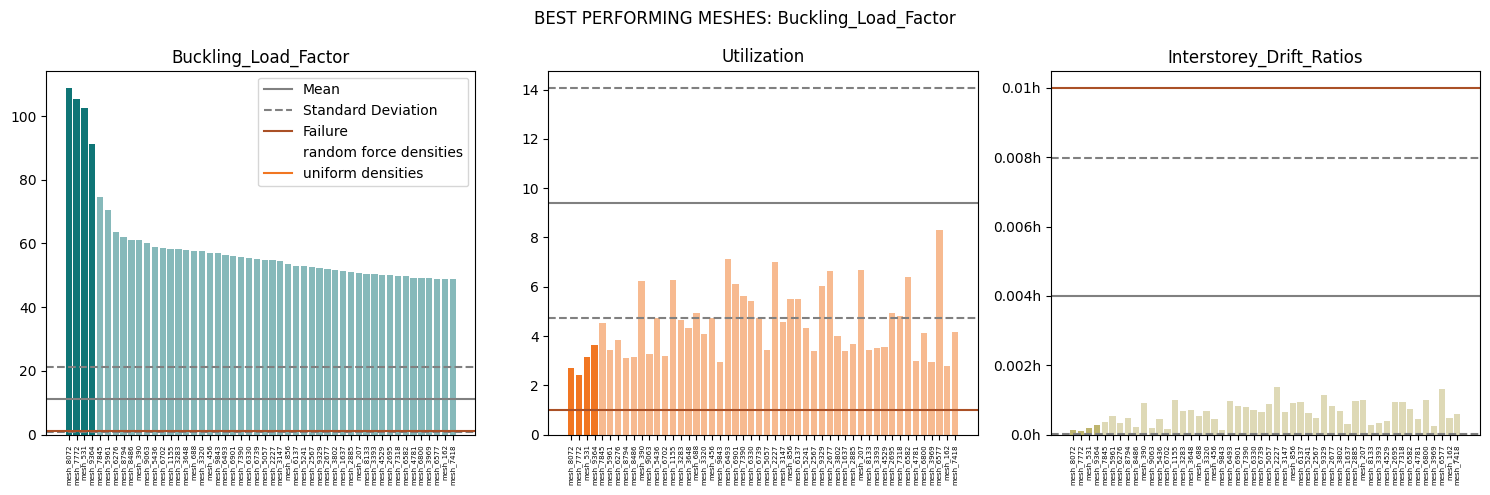

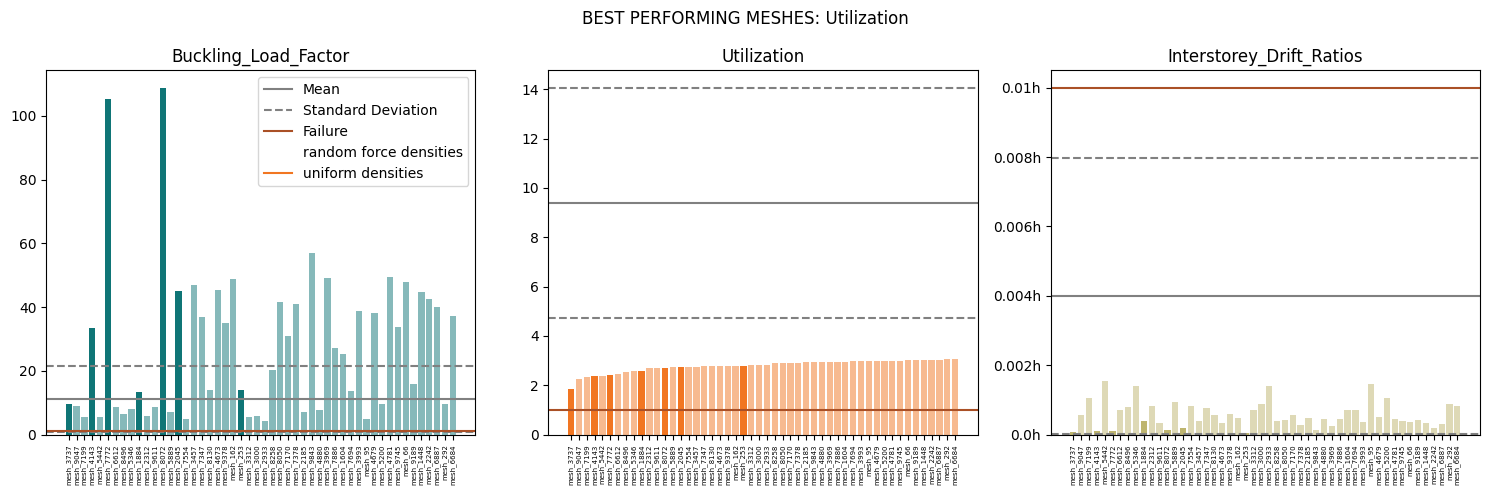

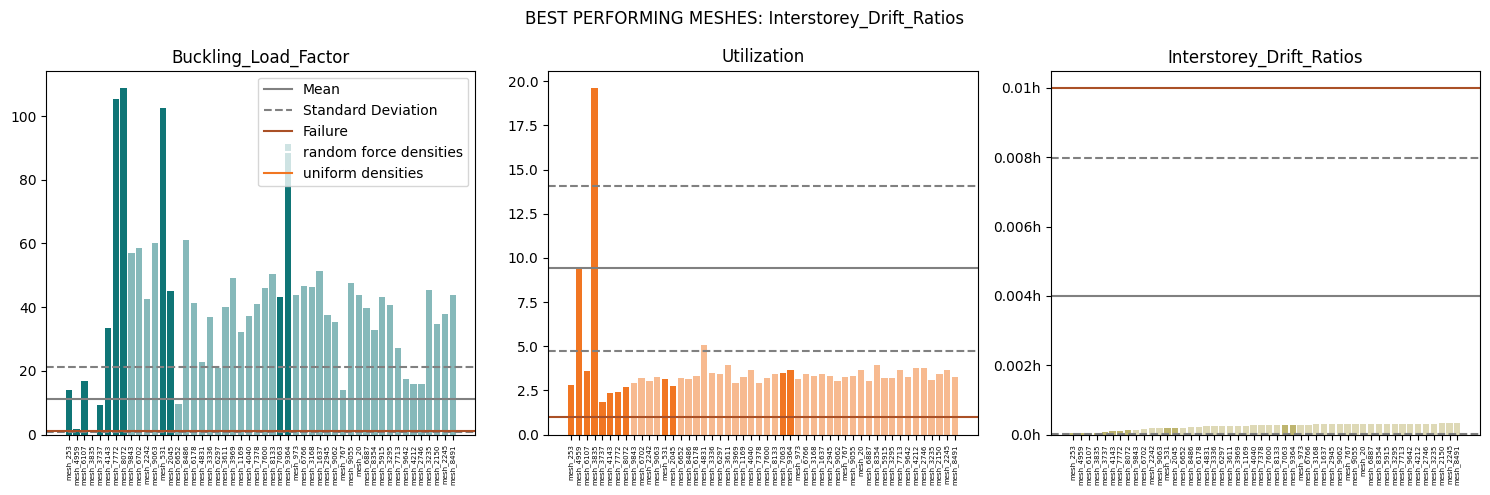

In [18]:
# PLOT BEST MESHES IN SSS
best_meshes_path = os.path.join(parent_path, 'plots','best_meshes', datasets[0])
os.makedirs(best_meshes_path, exist_ok=True)

colour_list_1 = [colour_teal, colour_orange, colour_gold]

def sss_graph_from_test_meshes(data, sss_type):

    data = data[sss_type]
    mesh_key = list(data.keys())[0]

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting
    for i, subkey in enumerate(data[mesh_key].keys()):
        ax = axs[i]
        for mesh, values in data.items():
            ax.bar(mesh, values[subkey][0], color= colour_list_1[i],alpha=1.0 if mesh in uniform_mesh_ids else 0.5)
        ax.set_title(subkey)
        ax.tick_params(axis='x', labelsize = 5, labelrotation=90)  # Rotate x-axis labels by 90 degrees
        ax.axhline(mean_dict[subkey], color='gray', linestyle='solid', label='Mean')
        ax.axhline(mean_dict[subkey] - std_dict[subkey], color='gray', linestyle='--', label='Standard Deviation')
        ax.axhline(mean_dict[subkey] + std_dict[subkey], color='gray', linestyle='--', label='Standard Deviation')
        ax.axhline(failure_dict[subkey], color=colour_maroon, linestyle='solid', label='Standard Deviation')
        if subkey == 'Interstorey_Drift_Ratios':
            axs[i].set_yticklabels([f'{round(label,3)}h' for label in axs[i].get_yticks()])

    # Set labels and title
    fig.suptitle(f'BEST PERFORMING MESHES: {sss_type}')
    # Add custom legend for mean, standard deviation, and failure lines
    custom_legend = [
        plt.Line2D([0], [0], color='gray', linestyle='solid', label='Mean'),
        plt.Line2D([0], [0], color='gray', linestyle='--', label='Standard Deviation'),
        plt.Line2D([0], [0], color=colour_maroon, linestyle='solid', label='Failure'),
        plt.Line2D([0], [0], color= 'white', linestyle='solid', label='random force densities'),
        plt.Line2D([0], [0], color= colour_orange, linestyle='solid', label='uniform densities')
    ]
    axs[0].legend(handles=custom_legend)

    plt.tight_layout()
    plt.savefig(os.path.join(best_meshes_path,f'best_{sss_type}.png'), dpi=300)
    plt.show()


# PLOT BEST MESHES IN BUCKLING PERFORMANCE
sss_graph_from_test_meshes(best_sss_dict, 'Buckling_Load_Factor')
# PLOT BEST MESHES IN UTILIZATION PERFORMANCE
sss_graph_from_test_meshes(best_sss_dict, 'Utilization')
# PLOT BEST MESHES IN INTERSTOREY DRIFT PERFORMANCE
sss_graph_from_test_meshes(best_sss_dict, 'Interstorey_Drift_Ratios')

In [42]:
# GENERATING INDICES AND GETTING THE DATASET FOR X_TRAIN

'''
this part of code is copied from vae_tz_4.ipynb
'''


# converting csv into array
dataset = pd.read_csv(os.path.join(dataset_file_path,'dataset.csv'))
dataset = dataset.values
dataset = dataset.transpose()


###################################################################################################
############################ GENERATE INDICES FOR TEST AND TRAIN DATA #############################
###################################################################################################

'''ONLY GENERATE THIS ONCE FOR A PARTICULAR DATASET SO THE TEST MESHES REMAIN THE SAME!'''


if not (os.path.exists(os.path.join(main_path,f'indices_test_{test_indices_no}.npy')) or os.path.exists(os.path.join(main_path,f'indices_train_{test_indices_no}.npy'))): 

    BOOLEAN_generate_indices = True

    # BEST INDICES (10 EACH FROM SSS) AND REMOVING THEM FROM TRAIN_INDICES
    best_indices = {}
    for key in ['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']:
        best_indices[key]=best_sss_meshes[key][:10]
        best_indices[key]=[int(i[5:])for i in best_indices[key]]

    # Save best indices
    with open(os.path.join(main_path,'indices_best_test.json'), 'w') as file:
        json.dump(best_indices, file)

    # Converting best indices into dictionary for each SSS   
    best_indices_arr = np.array([best_indices['Buckling_Load_Factor'],best_indices['Utilization'],best_indices['Interstorey_Drift_Ratios']])
    best_indices_dict = {}
    best_indices_dict['Buckling_Load_Factor'] = best_indices_arr[0]
    best_indices_dict['Utilization'] = best_indices_arr[1]
    best_indices_dict['Interstorey_Drift_Ratios'] = best_indices_arr[2]

    # train_items = int(0.75*dataset.shape[0])
    test_items = test_indices_no
    train_items = dataset.shape[0] - test_items

    #generating random indices
    random_indices_original = np.random.choice(dataset.shape[0],train_items,replace=False)
    # remaining indices for test data
    all_indices = np.arange(dataset.shape[0])
    remaining_indices_original = np.setdiff1d(all_indices,random_indices_original)

    # Removing best indices from training indices
    best_indices_all = np.concatenate((best_indices_dict['Buckling_Load_Factor'],best_indices_dict['Utilization'],best_indices_dict['Interstorey_Drift_Ratios']))
    best_indices_all = np.unique(best_indices_all)
    mask_best_indices_all = ~np.isin(random_indices_original,best_indices_all)
    random_indices_updated = random_indices_original[mask_best_indices_all]

    # Save remaining indices
    np.save(os.path.join(main_path,f'indices_test_{test_indices_no}.npy'), remaining_indices_original)
    np.save(os.path.join(main_path,f'indices_train_{test_indices_no}.npy'), random_indices_updated)
    remaining_indices = remaining_indices_original
    random_indices = random_indices_updated
    
else:

    BOOLEAN_generate_indices = False

    # Load remaining indices
    remaining_indices = np.load(os.path.join(main_path,f'indices_test_{test_indices_no}.npy'))
    # Load random indices
    random_indices = np.load(os.path.join(main_path,f'indices_train_{test_indices_no}.npy'))
    
    # Load best indices
    with open(os.path.join(main_path,'indices_best_test.json')) as file:
        best_indices = json.load(file)
    # Converting best indices into dictionary for each SSS   
    best_indices_arr = np.array([best_indices['Buckling_Load_Factor'],best_indices['Utilization'],best_indices['Interstorey_Drift_Ratios']])
    best_indices_dict = {}
    best_indices_dict['Buckling_Load_Factor'] = best_indices_arr[0]
    best_indices_dict['Utilization'] = best_indices_arr[1]
    best_indices_dict['Interstorey_Drift_Ratios'] = best_indices_arr[2]

print(f"Generate indices for train/test data?: {BOOLEAN_generate_indices}")

Generate indices for train/test data?: True


In [ ]:
print(best_sss_dict['Buckling_Load_Factor'].keys())

list_1 = set(best_indices_dict['Buckling_Load_Factor']) & set(best_indices_dict['Utilization'])
print(list_1)
list_2 = set(best_indices_dict['Interstorey_Drift_Ratios']) & set(best_indices_dict['Utilization'])
print(list_2)
list_3 = set(best_indices_dict['Interstorey_Drift_Ratios']) & set(best_indices_dict['Buckling_Load_Factor'])
print(list_3)
list_4 = set(best_indices_dict['Buckling_Load_Factor']) & set(best_indices_dict['Utilization']) & set(best_indices_dict['Interstorey_Drift_Ratios'])
print(list_4)


dict_keys(['mesh_8072', 'mesh_7772', 'mesh_531', 'mesh_9364', 'mesh_7845', 'mesh_5961', 'mesh_6276', 'mesh_8794', 'mesh_8486', 'mesh_390', 'mesh_9063', 'mesh_5436', 'mesh_6702', 'mesh_1155', 'mesh_3283', 'mesh_3648', 'mesh_688', 'mesh_3320', 'mesh_456', 'mesh_9843', 'mesh_6493', 'mesh_6901', 'mesh_7390', 'mesh_6330', 'mesh_6739', 'mesh_5057', 'mesh_2227', 'mesh_3147', 'mesh_856', 'mesh_6137', 'mesh_5241', 'mesh_2567', 'mesh_9329', 'mesh_2677', 'mesh_3802', 'mesh_1637', 'mesh_2885', 'mesh_207', 'mesh_8133', 'mesh_3393', 'mesh_4529', 'mesh_2695', 'mesh_7318', 'mesh_6582', 'mesh_4781', 'mesh_6800', 'mesh_3969', 'mesh_6577', 'mesh_162', 'mesh_7418'])
{7772}
{3737, 7772, 4143}
{8072, 7772}
{7772}


In [ ]:
# CHECK THICKNESS WISE TRENDS
import copy


thickness_path = os.path.join(parent_path,'thickness_dataset.json')
with open(thickness_path, 'r') as file:
    thickness_dataset = json.load(file)
thickness_dataset =  [i/1000 for i in thickness_dataset]


thickness_dict = copy.deepcopy(pa_dict_sorted['without_failure'])
for i, mesh in enumerate(thickness_dict.keys()):
    thickness_dict[mesh].append(thickness_dataset[i])

data = thickness_dict


C:\Users\tahir\AppData\Local\Temp\ipykernel_20688\356709721.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[key_index].set_yticklabels([f'{round(label,3)}h' for label in axs[key_index].get_yticks()])


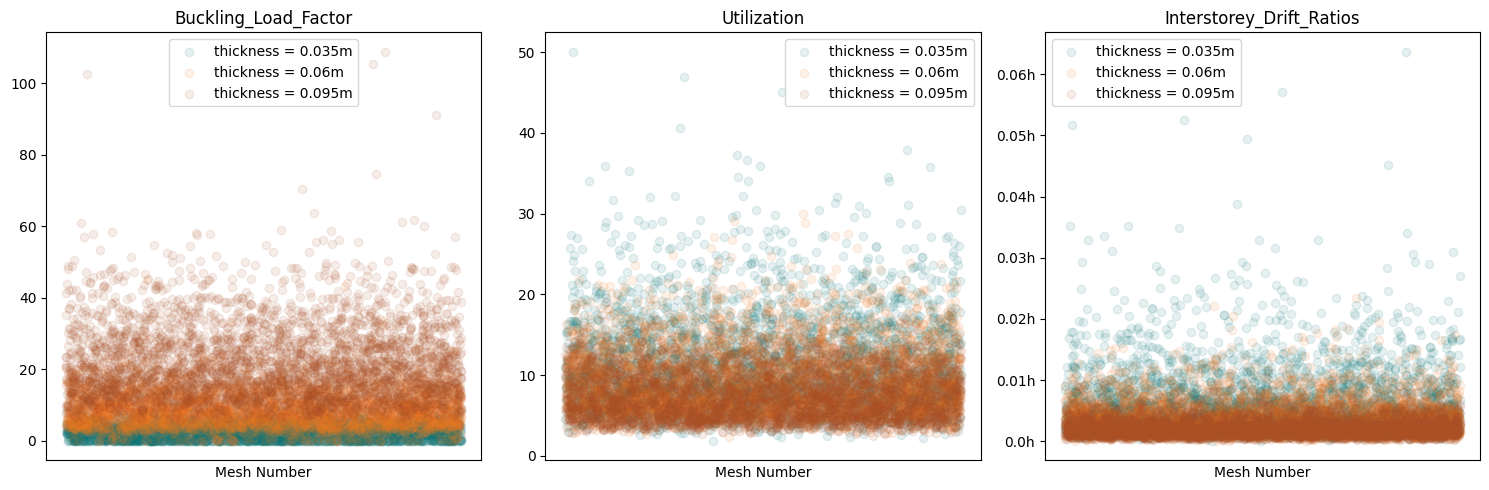

In [ ]:
# PLOT THICKNESS VS MESH NUMBER

parent_plot_path = os.path.join(parent_path,'plots','thickness_vs_performance')
# Create a results folder in the main directory if it doesn't exist
os.makedirs(parent_plot_path,exist_ok=True)


# turning mesh numbers into array 
meshes = list(data.keys())
meshes = [float(i[5:])for i in meshes]
mesh_arr = np.array(meshes)
mesh_arr = mesh_arr.reshape(-1,1)

# adding mesh number as column in the array
sss_arr = np.array([i[:3] for i in data.values()])
sss_arr = np.hstack((sss_arr,mesh_arr))

# thickness array
thickness_arr = np.array([i[3] for i in data.values()])


# list of 3 thicknesses
thickness_list = set(thickness_dataset)
thickness_list = list(i for i in thickness_list)
thickness_list.sort()


# values according to thikckness
t1_indices = np.where(thickness_arr==thickness_list[0])[0]
t1_values = sss_arr[t1_indices]

t2_indices = np.where(thickness_arr==thickness_list[1])[0]
t2_values = sss_arr[t2_indices]

t3_indices = np.where(thickness_arr==thickness_list[2])[0]
t3_values = sss_arr[t3_indices]

value_list = [t1_values,t2_values,t3_values]



# Keys
keys = ['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']

# Create subplots
fig, axs = plt.subplots(1, len(keys), figsize=(15, 5))

# Plot each key against mesh number for all thicknesses in subplots


for key_index, key in enumerate(keys[:3]):
    for v, value in enumerate(value_list):
        y = value[:,key_index]
        x = value[:,3]
        colour = colour_list[v]

        axs[key_index].scatter(x, y, alpha=0.1, color=colour, label = f'thickness = {thickness_list[v]}m')
        if key == 'Interstorey_Drift_Ratios':
            axs[key_index].set_yticklabels([f'{round(label,3)}h' for label in axs[key_index].get_yticks()])

    axs[key_index].set_xlabel('Mesh Number')
    axs[key_index].set_title(f'{key}')
    axs[key_index].legend()
    axs[key_index].set_xticks([])  # Remove x ticks

plt.tight_layout()
plt.savefig(os.path.join(parent_plot_path,f'{datasets[0]}_thickness_vs_performance.png'))


C:\Users\tahir\AppData\Local\Temp\ipykernel_20688\1232927577.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[key_index].set_yticklabels([f'{round(label,3)}h' for label in axs[key_index].get_yticks()])


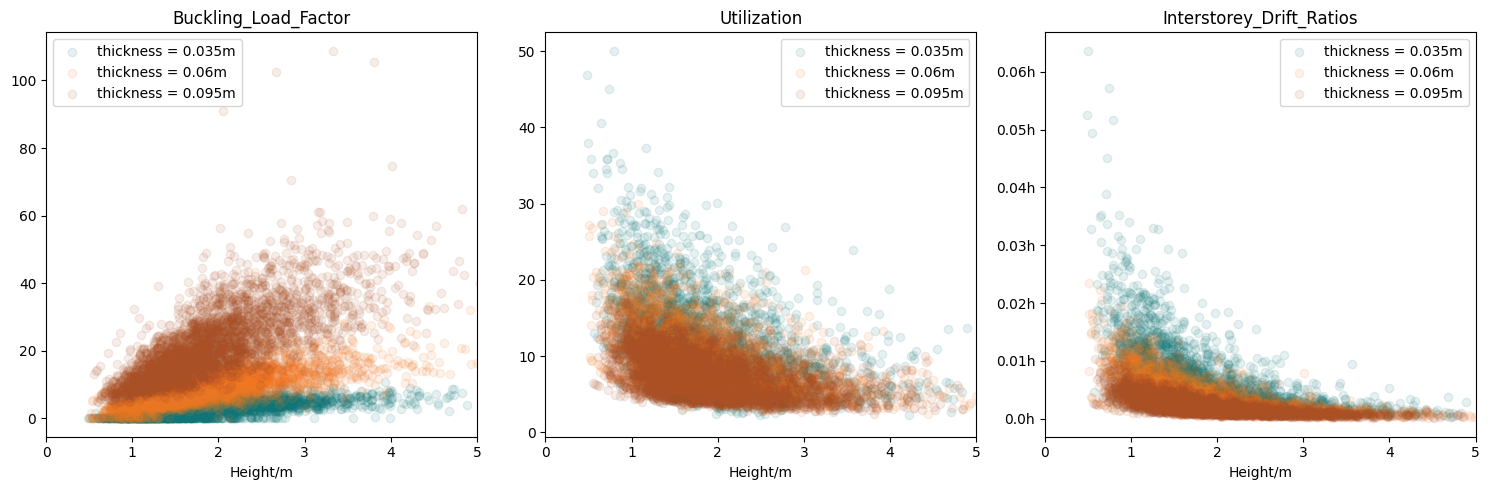

In [ ]:
# PLOT THICKNESS VS HEIGHT


# height dictionary
parent_path_gg= os.path.join(parent_path,datasets[0],'00_geometry_generation/dataset_separate/dataset_separate_height_thickness/' )
gg_height_dict= make_mesh_dict_from_files(parent_path_gg, 'gg')
gg_height_dict= extract_keys_from_nested_dict(gg_height_dict, ['Height_of_vault/m'], 'gg')

# Convert nested dictionary to DataFrame
df_gg_height = pd.DataFrame.from_dict(gg_height_dict)
# Sort column names in ascending order considering numerical part
sorted_gg_height = sorted(df_gg_height.columns, key=lambda x: int(x.split('mesh_')[-1]))
# Reorder DataFrame columns
df_gg_height = df_gg_height[sorted_gg_height]

height_arr = np.array(df_gg_height.iloc[0].tolist())



#################################################################


# turning mesh numbers into array 
height_arr = np.array(df_gg_height.iloc[0].tolist())
height_arr = height_arr.reshape(-1,1)

# adding mesh number as column in the array
sss_arr = np.array([i[:3] for i in data.values()])
sss_arr = np.hstack((sss_arr,height_arr))

# thickness array
thickness_arr = np.array([i[3] for i in data.values()])


# list of 3 thicknesses
thickness_list = set(thickness_dataset)
thickness_list = list(i for i in thickness_list)
thickness_list.sort()


# values according to thikckness
t1_indices = np.where(thickness_arr==thickness_list[0])[0]
t1_values = sss_arr[t1_indices]

t2_indices = np.where(thickness_arr==thickness_list[1])[0]
t2_values = sss_arr[t2_indices]

t3_indices = np.where(thickness_arr==thickness_list[2])[0]
t3_values = sss_arr[t3_indices]

value_list = [t1_values,t2_values,t3_values]



# Keys
keys = ['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']

# Create subplots
fig, axs = plt.subplots(1, len(keys), figsize=(15, 5))

# Plot each key against mesh number for all thicknesses in subplots


for key_index, key in enumerate(keys[:3]):
    for v, value in enumerate(value_list):
        y = value[:,key_index]
        x = value[:,3]
        colour = colour_list[v]

        axs[key_index].scatter(x, y, alpha=0.1, color=colour, label = f'thickness = {thickness_list[v]}m')
        if key == 'Interstorey_Drift_Ratios':
            axs[key_index].set_yticklabels([f'{round(label,3)}h' for label in axs[key_index].get_yticks()])
    

    axs[key_index].set_xlabel('Height/m')
    axs[key_index].set_title(f'{key}')
    axs[key_index].legend()
    axs[key_index].set_xlim(0,5)
    # axs[key_index].set_xticks([])  # Remove x ticks

plt.tight_layout()
plt.savefig(os.path.join(parent_plot_path,f'{datasets[0]}_thickness_vs_performance_vs_height.png'))



In [ ]:
# AVERAGE CHANGE IN PERFORMANCE OVER THICKNESS

t1_avg = np.average(t1_values,axis=0)
t2_avg = np.average(t2_values,axis=0)
t3_avg = np.average(t3_values,axis=0)

t1_to_t2 = list((t2_avg - t1_avg)*100/t1_avg)[:-1]
t2_to_t3 = list((t3_avg - t2_avg)*100/t3_avg)[:-1]

t1_to_t2= [round(i,2) for i in t1_to_t2]
t2_to_t3= [round(i,2) for i in t1_to_t2]

print('-----------------------------------------------------------')
print(f"-------PERFORMANCE CHANGE WHEN THICKNESS INCREASES--------")
print('-----------------------------------------------------------')
print(f"------------From single layer to double layers------------")
print(f"Buckling_Load_Factor change = {t1_to_t2[0]}%")
print(f"Utilization change = {t1_to_t2[1]}%")
print(f"Interstorey_Drift_Ratio change = {t1_to_t2[2]}%")
print('-----------------------------------------------------------')
print(f"------------From double layer to triple layers------------")
print(f"Buckling_Load_Factor change = {t2_to_t3[0]}%")
print(f"Utilization change = {t2_to_t3[1]}%")
print(f"Interstorey_Drift_Ratio change = {t2_to_t3[2]}%")

-----------------------------------------------------------
-------PERFORMANCE CHANGE WHEN THICKNESS INCREASES--------
-----------------------------------------------------------
------------From single layer to double layers------------
Buckling_Load_Factor change = 213.41%
Utilization change = -16.32%
Interstorey_Drift_Ratio change = -38.54%
-----------------------------------------------------------
------------From double layer to triple layers------------
Buckling_Load_Factor change = 213.41%
Utilization change = -16.32%
Interstorey_Drift_Ratio change = -38.54%


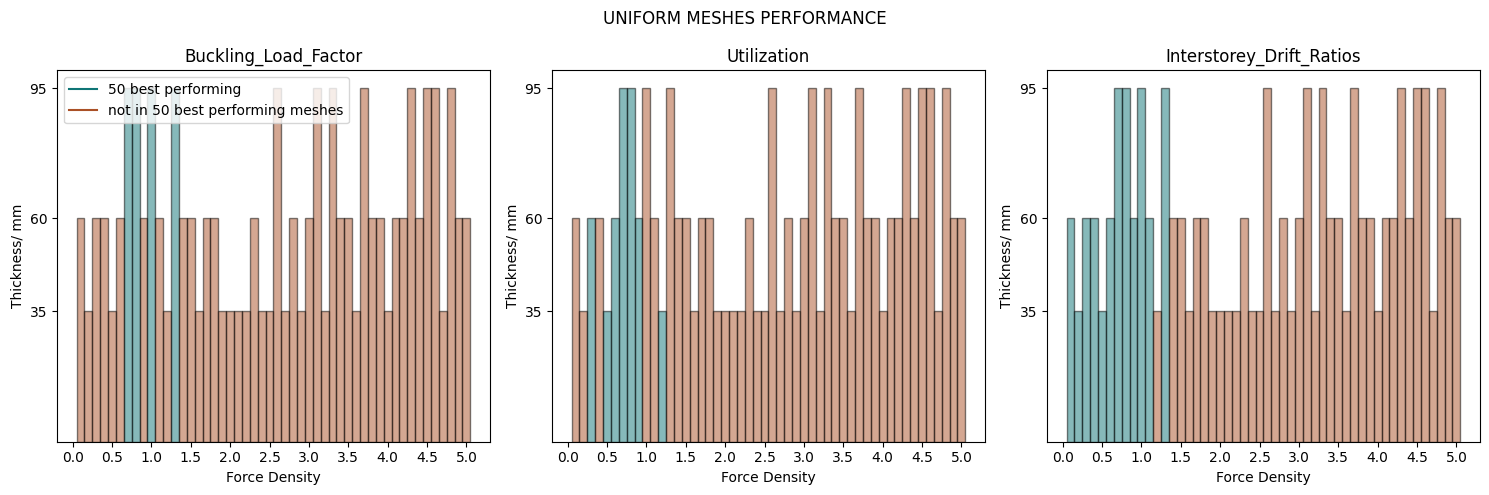

In [ ]:
# PLOT THICKNESS VS FORCE DENSITIES TO SEE IF UNIFORM MESHES ARE ALSO IN BEST PERFORMING ONES


df_fd_path = os.path.join(parent_path, datasets[0], '00_geometry_generation/dataset/dataset.csv')
df_fd = pd.read_csv(df_fd_path)
    
fig,axs = plt.subplots(1,3, figsize = (15,5))

for i, key in  enumerate(['Buckling_Load_Factor', 'Utilization', 'Interstorey_Drift_Ratios']):
    ax = axs[i]
    for mesh in uniform_mesh_ids:
        y = thickness_dict[mesh][3]*1000
        x = df_fd[mesh].tolist()[0]
        ax.bar(x,y, color = colour_maroon if mesh not in uniform_best_dict[key] else colour_teal, alpha=0.5, edgecolor= 'black', width = 0.1)
    ax.set_title(key)
    ax.tick_params(axis='x', labelsize = 10)  # Rotate x-axis labels by 90 degrees
    ax.set_ylabel('Thickness/ mm')
    ax.set_xlabel('Force Density')
    ax.set_yticks([35,60,95])
    ax.set_xticks(list(np.arange(0,5.5,0.5)))

    # ax.set_xlim(0,5)

# Set labels and title
fig.suptitle(f'UNIFORM MESHES PERFORMANCE')
# Add custom legend for mean, standard deviation, and failure lines
custom_legend = [
    plt.Line2D([0], [0], color= colour_teal, linestyle='solid', label='50 best performing'),
    plt.Line2D([0], [0], color= colour_maroon, linestyle='solid', label='not in 50 best performing meshes')
]
axs[0].legend(handles=custom_legend)

plt.tight_layout()
plt.savefig(os.path.join(best_meshes_path,f'uniform_fd_thickness_best_or_not.png'), dpi=300)
plt.show()
